# Amazon Reviews Sentiment Analysis


In [124]:
import string
import nltk
import re
from textblob import TextBlob
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
string.punctuation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [125]:
import os

def load_reviews(folder_path):
    reviews = [] # empty list for the reviews
    ratings = os.path.basename(folder_path) # the folder name is the ratings i.e. ..reviews/1 is 1 star etc
    
    for filename in os.listdir(folder_path): # iterate thru all files in the folder
        filepath = os.path.join(folder_path, filename) 

        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8') as file:
                reviews.append({'review': file.read(), 'rating': rating})
                
    return pd.DataFrame(reviews)
    

In [126]:
all_dfs = [] # empty list

# cycle thru each folder -- ie 'Data/reviews/1 , Data/reviews/2 , etc.'
for rating in range(1, 6):
    df_temp = load_reviews(os.path.join('/Users/jacquelineduong/Downloads/reviews', str(rating)))
    all_dfs.append(df_temp)


In [127]:
df = pd.concat(all_dfs, ignore_index=True)

In [128]:
df

,review,rating
0,Does not lay flat. Cord barely fits in channel and it is not tapered to prevent someone from catching their foot. Does not look like the sample pictures. Perhaps makes the cord a bigger trip hazard as it does not lay flat no matter how you push it down or pull the cord through. Don’t waste your money.,1
1,Only had it for 5 months and it doesn’t work now at all nd this is my second pair within the first week had to get a replacement caz the sound was so low u couldn’t hear nothing nd no it’s sound but no one can hear u..,1
2,"This is advertised to contain more than 26' of tape. I purchased two, installed one and immediately printed 10-15 identical 5” labels (to add to some I had printed when my previous tape ran out). To my shock, the new tape ran out in a little more than a minute, if that. I don’t know how many labels I printed; but, including the identical tapes I had printed from the previous cassette, I had 23 tapes (a total of less than 10’ of tape—not all from this cassette. I have used several of these tape cassettes over several years with total satisfaction. They are expensive and entering text is slow, but I very much like the finished product.I wondered if these were counterfeit “knock offs,” but the packaging and end product seemed consistent with past experiences. Perhaps it was a one-of quality control problem. But based on this experience, I can’t give it a high rating.",1
3,This was supposed to be a gift to me from my wife but I had to open it early and see if it was damaged due to the box arriving completely destroyed.I have been using SanDisk SD and Micro SD cards exclusively as a photographer without any problems. But this should have been tested and put in a new box..For the price of this card this is unacceptable. Because the missing pieces of the package were not inside the box I know it was shipped like that..I may need to re-evaluate the brand I use for my photography business and recommend to othersPlease note: the card works but I am displeased at the condition they shipped it in. So be careful if you consider buying from this seller,1
4,"The item arrived with wear and tear. I tried turning them on but they didn’t turn on. I decided to charge them and after charging them for several hours they still didn’t turn on. I was super disappointed, I thought Rode and Amazon were reliable. Please check who your getting your supplies from, it seems this might have been returned and weren’t checked to see if they even worked.",1
...,...,...
20995,Frankly I was skeptical that any phone stand could be well-built and sturdy for a bargain price. I was pleasantly surprised at my purchase. It has pads on the underside that hold it firmly on the desk. It also has pads on the cradle and back to keep the phone in place when on it. Best of all it allows the phone to be charged while in landscape or portrait. I plan to buy a second one for my workshop.,5
20996,"This is a very sturdy and sleek looking cell phone stand. In the past, I bought another kind which is fine, but this one is excellent and great price!",5
20997,Helpful instructions. Easy to mount. Sturdy,5
20998,"While this mount isn't the highest rated for folding flat to the wall, it's range of motion is awesome. Works perfectly for pulling the TV out and angling so it can be seen from across the room. I needed a long extension and large angle so my 65"" TV could be watched from the pool table. This is built very sturdy and doesn't wobble or bend down when extended. Just what I needed!",5


In [90]:
df.duplicated().sum()

14509

In [35]:
duplicated_rows = df[df.duplicated(keep=False)]
print(duplicated_rows.sort_values(by="review").head(20))


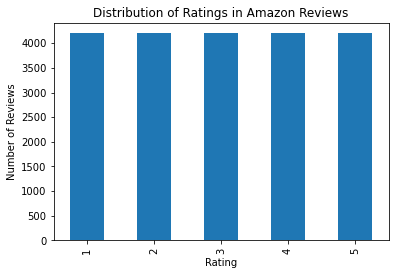

In [36]:
# number of reviews per rating score
df['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings in Amazon Reviews')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [37]:
#display full content of reviews
pd.set_option('display.max_colwidth', None)

# getting 2 samples from each rating score
for rating in range(1, 6):
    sample = df[df['rating'] == rating].sample(2)
    print(sample)
    print('-'*80)  


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review  \
2270  I ordered a two-pack of these earphones. Now, I wasn’t expecting them to be the best since it was two of them for a cheap price but they’re practically unusable. First off, they need to be connected toBlue tooth which I wasn’t expecting but whatever. The person on the other end sounds like they’re muffled or underwater. Both of the ear phones are faulty. My sister got one for my mom as well at the same time as I ordered mine and they were faulty as well. DO NOT BUY.   
2523                                    

From this example I see there are some different languages in here. Let's try to filter to only English

In [91]:
!pip install langdetect

In [92]:
from langdetect import detect, DetectorFactory

# Use random seed for reproducability
DetectorFactory.seed = 0

def is_english(text):
    try:
        # Return True if EN else flase
        return detect(text) == 'en' # True
    except:
        return False



In [93]:
# Filter df English reviews only
df_english_only = df[df['review'].apply(is_english)]

In [94]:
# number of non-english samples
df.shape[0] - df_english_only.shape[0]

339

### Sentiment Visualization

In [129]:
def get_sentiment(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

In [130]:
df['sentiment'] = df['review'].apply(get_sentiment)
df

,review,rating,sentiment
0,Does not lay flat. Cord barely fits in channel and it is not tapered to prevent someone from catching their foot. Does not look like the sample pictures. Perhaps makes the cord a bigger trip hazard as it does not lay flat no matter how you push it down or pull the cord through. Don’t waste your money.,1,0.034921
1,Only had it for 5 months and it doesn’t work now at all nd this is my second pair within the first week had to get a replacement caz the sound was so low u couldn’t hear nothing nd no it’s sound but no one can hear u..,1,0.175000
2,"This is advertised to contain more than 26' of tape. I purchased two, installed one and immediately printed 10-15 identical 5” labels (to add to some I had printed when my previous tape ran out). To my shock, the new tape ran out in a little more than a minute, if that. I don’t know how many labels I printed; but, including the identical tapes I had printed from the previous cassette, I had 23 tapes (a total of less than 10’ of tape—not all from this cassette. I have used several of these tape cassettes over several years with total satisfaction. They are expensive and entering text is slow, but I very much like the finished product.I wondered if these were counterfeit “knock offs,” but the packaging and end product seemed consistent with past experiences. Perhaps it was a one-of quality control problem. But based on this experience, I can’t give it a high rating.",1,0.031604
3,This was supposed to be a gift to me from my wife but I had to open it early and see if it was damaged due to the box arriving completely destroyed.I have been using SanDisk SD and Micro SD cards exclusively as a photographer without any problems. But this should have been tested and put in a new box..For the price of this card this is unacceptable. Because the missing pieces of the package were not inside the box I know it was shipped like that..I may need to re-evaluate the brand I use for my photography business and recommend to othersPlease note: the card works but I am displeased at the condition they shipped it in. So be careful if you consider buying from this seller,1,-0.012662
4,"The item arrived with wear and tear. I tried turning them on but they didn’t turn on. I decided to charge them and after charging them for several hours they still didn’t turn on. I was super disappointed, I thought Rode and Amazon were reliable. Please check who your getting your supplies from, it seems this might have been returned and weren’t checked to see if they even worked.",1,-0.138889
...,...,...,...
20995,Frankly I was skeptical that any phone stand could be well-built and sturdy for a bargain price. I was pleasantly surprised at my purchase. It has pads on the underside that hold it firmly on the desk. It also has pads on the cradle and back to keep the phone in place when on it. Best of all it allows the phone to be charged while in landscape or portrait. I plan to buy a second one for my workshop.,5,0.066667
20996,"This is a very sturdy and sleek looking cell phone stand. In the past, I bought another kind which is fine, but this one is excellent and great price!",5,0.494444
20997,Helpful instructions. Easy to mount. Sturdy,5,0.433333
20998,"While this mount isn't the highest rated for folding flat to the wall, it's range of motion is awesome. Works perfectly for pulling the TV out and angling so it can be seen from across the room. I needed a long extension and large angle so my 65"" TV could be watched from the pool table. This is built very sturdy and doesn't wobble or bend down when extended. Just what I needed!",5,0.306406


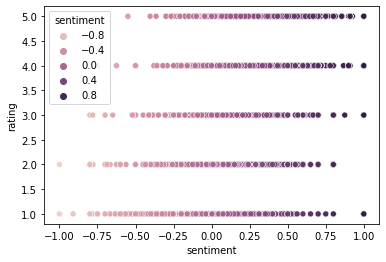

In [131]:
sns.scatterplot(data=df, x='sentiment', y='rating', hue='sentiment')
plt.savefig("scatterplot.png")
plt.show()

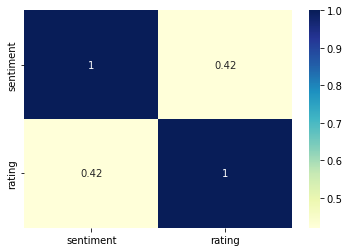

In [132]:
sns.heatmap(df[['sentiment', 'rating']].corr(), annot=True, cmap='YlGnBu')
plt.savefig("correlationheatmap.png")
plt.show()

### Binary Classification

I am going to start with simply classifying positive and negative sentiment. To do this I will consider 4 and 5 star reviews positive, 1 and 2 star reviews negative, and leave 3 star (neutral) reviews out for now. 

In [15]:
# filter out neutral reviews
df_binary = df_english_only[df_english_only['rating'] != 3].copy()

# apply pos is 4 or 5, neg is 1 or 2
df_binary['sentiment'] = df_binary['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')



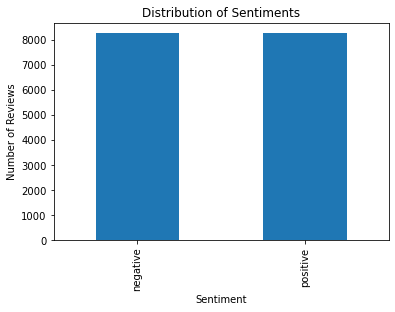

In [16]:
df_binary['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

Lets take a look at some of the most common words associated with both positive and negative reviews.

In [17]:
#seperating out pos and neg reviews
positive_reviews = df_binary[df_binary['sentiment'] == 'positive']['review']
negative_reviews = df_binary[df_binary['sentiment'] == 'negative']['review']

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

#instantiate count vectorizer with english stop words
countvec_pos = CountVectorizer(stop_words='english')
countvec_neg = CountVectorizer(stop_words='english')

#vectorize both pos and neg reviews
pos = countvec_pos.fit_transform(positive_reviews)
neg = countvec_neg.fit_transform(negative_reviews)

In [19]:
pos.shape, neg.shape

((8271, 13648), (8271, 10205))

In [20]:
# create 2 df for each positive and negative words
pos_word_counts = pd.DataFrame(
    {"counts": pos.toarray().sum(axis=0)},
    index=countvec_pos.get_feature_names_out()
).sort_values("counts", ascending=False)

neg_word_counts = pd.DataFrame(
    {"counts": neg.toarray().sum(axis=0)},
    index=countvec_neg.get_feature_names_out()
).sort_values("counts", ascending=False)

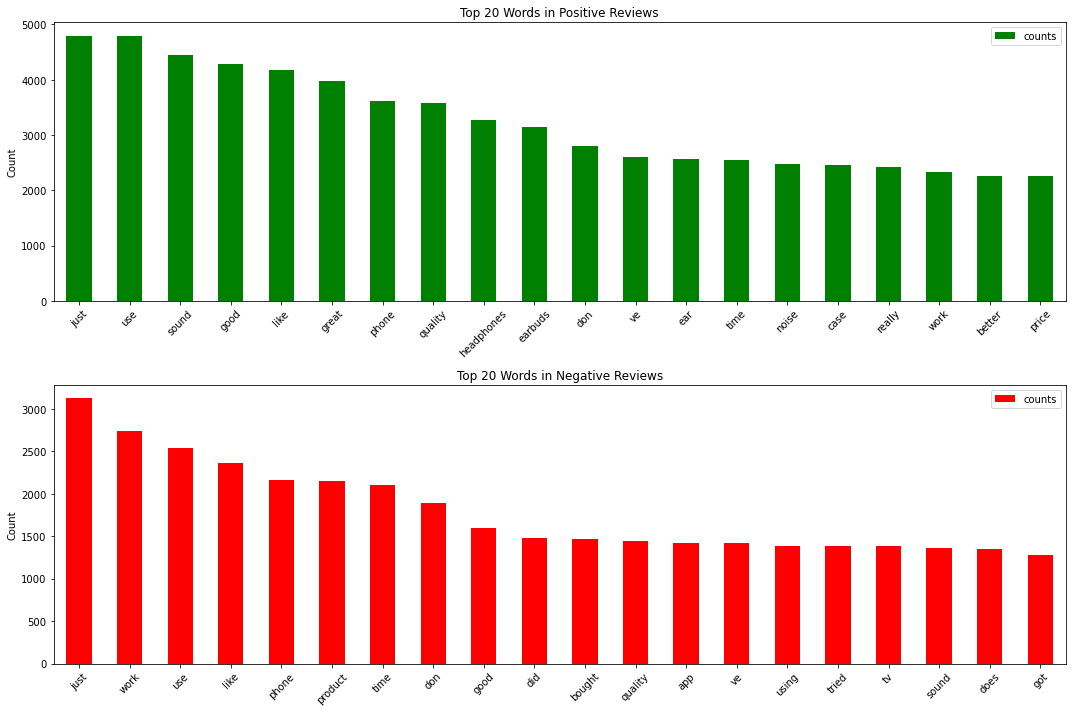

In [21]:


# Plotting for Positive Reviews
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
pos_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='green')
plt.title('Top 20 Words in Positive Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plotting for Negative Reviews
plt.subplot(2, 1, 2)
neg_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='red')
plt.title('Top 20 Words in Negative Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Good, Neutral, Bad

In [110]:
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

In [111]:
df['rating'] = df['rating'].apply(rating)

In [112]:
df

,review,rating
0,Does not lay flat. Cord barely fits in channel and it is not tapered to prevent someone from catching their foot. Does not look like the sample pictures. Perhaps makes the cord a bigger trip hazard as it does not lay flat no matter how you push it down or pull the cord through. Don’t waste your money.,Bad
1,Only had it for 5 months and it doesn’t work now at all nd this is my second pair within the first week had to get a replacement caz the sound was so low u couldn’t hear nothing nd no it’s sound but no one can hear u..,Bad
2,"This is advertised to contain more than 26' of tape. I purchased two, installed one and immediately printed 10-15 identical 5” labels (to add to some I had printed when my previous tape ran out). To my shock, the new tape ran out in a little more than a minute, if that. I don’t know how many labels I printed; but, including the identical tapes I had printed from the previous cassette, I had 23 tapes (a total of less than 10’ of tape—not all from this cassette. I have used several of these tape cassettes over several years with total satisfaction. They are expensive and entering text is slow, but I very much like the finished product.I wondered if these were counterfeit “knock offs,” but the packaging and end product seemed consistent with past experiences. Perhaps it was a one-of quality control problem. But based on this experience, I can’t give it a high rating.",Bad
3,This was supposed to be a gift to me from my wife but I had to open it early and see if it was damaged due to the box arriving completely destroyed.I have been using SanDisk SD and Micro SD cards exclusively as a photographer without any problems. But this should have been tested and put in a new box..For the price of this card this is unacceptable. Because the missing pieces of the package were not inside the box I know it was shipped like that..I may need to re-evaluate the brand I use for my photography business and recommend to othersPlease note: the card works but I am displeased at the condition they shipped it in. So be careful if you consider buying from this seller,Bad
4,"The item arrived with wear and tear. I tried turning them on but they didn’t turn on. I decided to charge them and after charging them for several hours they still didn’t turn on. I was super disappointed, I thought Rode and Amazon were reliable. Please check who your getting your supplies from, it seems this might have been returned and weren’t checked to see if they even worked.",Bad
...,...,...
20995,Frankly I was skeptical that any phone stand could be well-built and sturdy for a bargain price. I was pleasantly surprised at my purchase. It has pads on the underside that hold it firmly on the desk. It also has pads on the cradle and back to keep the phone in place when on it. Best of all it allows the phone to be charged while in landscape or portrait. I plan to buy a second one for my workshop.,Good
20996,"This is a very sturdy and sleek looking cell phone stand. In the past, I bought another kind which is fine, but this one is excellent and great price!",Good
20997,Helpful instructions. Easy to mount. Sturdy,Good
20998,"While this mount isn't the highest rated for folding flat to the wall, it's range of motion is awesome. Works perfectly for pulling the TV out and angling so it can be seen from across the room. I needed a long extension and large angle so my 65"" TV could be watched from the pool table. This is built very sturdy and doesn't wobble or bend down when extended. Just what I needed!",Good


In [113]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [114]:
df['review']= df['review'].apply(lambda x:remove_punctuation(x))
df

,review,rating
0,Does not lay flat Cord barely fits in channel and it is not tapered to prevent someone from catching their foot Does not look like the sample pictures Perhaps makes the cord a bigger trip hazard as it does not lay flat no matter how you push it down or pull the cord through Don’t waste your money,Bad
1,Only had it for 5 months and it doesn’t work now at all nd this is my second pair within the first week had to get a replacement caz the sound was so low u couldn’t hear nothing nd no it’s sound but no one can hear u,Bad
2,This is advertised to contain more than 26 of tape I purchased two installed one and immediately printed 1015 identical 5” labels to add to some I had printed when my previous tape ran out To my shock the new tape ran out in a little more than a minute if that I don’t know how many labels I printed but including the identical tapes I had printed from the previous cassette I had 23 tapes a total of less than 10’ of tape—not all from this cassette I have used several of these tape cassettes over several years with total satisfaction They are expensive and entering text is slow but I very much like the finished productI wondered if these were counterfeit “knock offs” but the packaging and end product seemed consistent with past experiences Perhaps it was a oneof quality control problem But based on this experience I can’t give it a high rating,Bad
3,This was supposed to be a gift to me from my wife but I had to open it early and see if it was damaged due to the box arriving completely destroyedI have been using SanDisk SD and Micro SD cards exclusively as a photographer without any problems But this should have been tested and put in a new boxFor the price of this card this is unacceptable Because the missing pieces of the package were not inside the box I know it was shipped like thatI may need to reevaluate the brand I use for my photography business and recommend to othersPlease note the card works but I am displeased at the condition they shipped it in So be careful if you consider buying from this seller,Bad
4,The item arrived with wear and tear I tried turning them on but they didn’t turn on I decided to charge them and after charging them for several hours they still didn’t turn on I was super disappointed I thought Rode and Amazon were reliable Please check who your getting your supplies from it seems this might have been returned and weren’t checked to see if they even worked,Bad
...,...,...
20995,Frankly I was skeptical that any phone stand could be wellbuilt and sturdy for a bargain price I was pleasantly surprised at my purchase It has pads on the underside that hold it firmly on the desk It also has pads on the cradle and back to keep the phone in place when on it Best of all it allows the phone to be charged while in landscape or portrait I plan to buy a second one for my workshop,Good
20996,This is a very sturdy and sleek looking cell phone stand In the past I bought another kind which is fine but this one is excellent and great price,Good
20997,Helpful instructions Easy to mount Sturdy,Good
20998,While this mount isnt the highest rated for folding flat to the wall its range of motion is awesome Works perfectly for pulling the TV out and angling so it can be seen from across the room I needed a long extension and large angle so my 65 TV could be watched from the pool table This is built very sturdy and doesnt wobble or bend down when extended Just what I needed,Good


In [115]:
#number of words in each review
sent_len = []
for sent in df['review']:
    sent_len.append(len(word_tokenize(sent)))
df['sent_len'] = sent_len
df.head()

,review,rating,sent_len
0,Does not lay flat Cord barely fits in channel and it is not tapered to prevent someone from catching their foot Does not look like the sample pictures Perhaps makes the cord a bigger trip hazard as it does not lay flat no matter how you push it down or pull the cord through Don’t waste your money,Bad,60
1,Only had it for 5 months and it doesn’t work now at all nd this is my second pair within the first week had to get a replacement caz the sound was so low u couldn’t hear nothing nd no it’s sound but no one can hear u,Bad,54
2,This is advertised to contain more than 26 of tape I purchased two installed one and immediately printed 1015 identical 5” labels to add to some I had printed when my previous tape ran out To my shock the new tape ran out in a little more than a minute if that I don’t know how many labels I printed but including the identical tapes I had printed from the previous cassette I had 23 tapes a total of less than 10’ of tape—not all from this cassette I have used several of these tape cassettes over several years with total satisfaction They are expensive and entering text is slow but I very much like the finished productI wondered if these were counterfeit “knock offs” but the packaging and end product seemed consistent with past experiences Perhaps it was a oneof quality control problem But based on this experience I can’t give it a high rating,Bad,164
3,This was supposed to be a gift to me from my wife but I had to open it early and see if it was damaged due to the box arriving completely destroyedI have been using SanDisk SD and Micro SD cards exclusively as a photographer without any problems But this should have been tested and put in a new boxFor the price of this card this is unacceptable Because the missing pieces of the package were not inside the box I know it was shipped like thatI may need to reevaluate the brand I use for my photography business and recommend to othersPlease note the card works but I am displeased at the condition they shipped it in So be careful if you consider buying from this seller,Bad,128
4,The item arrived with wear and tear I tried turning them on but they didn’t turn on I decided to charge them and after charging them for several hours they still didn’t turn on I was super disappointed I thought Rode and Amazon were reliable Please check who your getting your supplies from it seems this might have been returned and weren’t checked to see if they even worked,Bad,75


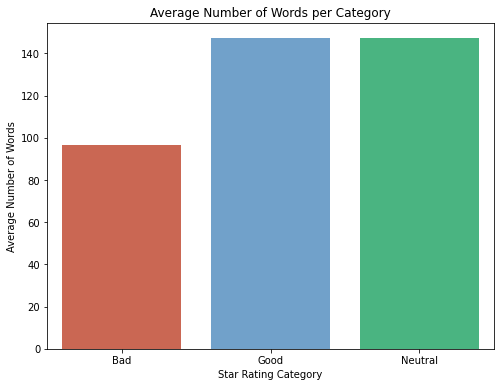

In [116]:
sns.set_palette(colors)

colors = ['#DE5A3F', '#62A2D9', '#38C682']
average_words_per_category = df.groupby('rating')['sent_len'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=average_words_per_category.index, y=average_words_per_category.values)
plt.title("Average Number of Words per Category")
plt.xlabel("Star Rating Category")
plt.ylabel("Average Number of Words")
plt.show()